In [10]:
import sys
import scipy.io as sio
sys.path.append('../core/')
sys.path.append('../networks/')
from ssl_conv import SSL_Encoder1, SSL_Encoder2, SSL_Decoder
from m2 import SSL_M2
from misc_ops import *

import numpy as np
import tensorflow as tf

import matplotlib.pyplot as plt
%matplotlib inline

from dataset import DataSet
from tensorflow.python.framework import dtypes

# for auto-reloading external modules
# see http://stackoverflow.com/questions/1907993/autoreload-of-modules-in-ipython
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [2]:
def mat2dataset(filepath):
    dat = sio.loadmat(filepath)
    x = dat['X']
    y = dat['y']
    y[y==10] = 0
    y = np.array(np.arange(10)==y, dtype=int)
    x = x.reshape((32*32*3,-1)).T
    return DataSet(x,y,dtype=dtypes.float32, reshape=False)

In [3]:
svhn_train = mat2dataset('SVHN/train_32x32.mat')
svhn_test = mat2dataset('SVHN/test_32x32.mat')
svhn_extra = mat2dataset('SVHN/extra_32x32.mat')

In [5]:
svhn_train.num_examples

73257

In [4]:
def split_data(dataset, num_labeled):
    """
    Split dataset into two datasets
    """
    n = dataset.num_examples
    x, y = dataset.next_batch(n)
    x1 = x[xrange(num_labeled),:]
    y1 = y[xrange(num_labeled),:]
    x2 = x[xrange(num_labeled, n),:]
    y2 = y[xrange(num_labeled, n),:]
    d1 = DataSet(x1, y1, dtype=dtypes.float32, reshape=False)
    d2 = DataSet(x2, y2, dtype=dtypes.float32, reshape=False)
    return d1, d2

In [7]:
# Split dataset into labeled and unlabeled
num_labeled = 70000
labeled, unlabeled = split_data(svhn_train, num_labeled)
_, y = labeled.next_batch(num_labeled)
print np.sum(y, axis=0)

[ 4728 13268 10137  8107  7136  6549  5456  5346  4815  4458]


In [20]:
tf.reset_default_graph()

In [21]:
# Train
sess = tf.InteractiveSession()
build_encoder1 = SSL_Encoder1(500)
build_encoder2 = SSL_Encoder2(500)
build_decoder = SSL_Decoder(500)

# as the number of labeled examples decreases, need alpha to decrease as well?
model = SSL_M2(sess, build_encoder1, build_encoder2, build_decoder, labeled, unlabeled,
            batch_size = 1000, z_dim = 30, x_dim = 32*32*3, y_dim=10, alpha=70000./10,
           learning_rate = 1e-3, num_epochs = 10, load=False,
          checkpoint_name='test'
)

In [22]:
model.train()

Epoch 1 loss: -265277.660789
Epoch 2 loss: -363034.953165
Epoch 3 loss: -443125.00813
Epoch 4 loss: -518189.717036
Epoch 5 loss: -590934.57709
Epoch 6 loss: -664716.684725
Epoch 7 loss: -736184.735559
Epoch 8 loss: -808334.880503
Epoch 9 loss: -881218.409202
Epoch 10 loss: -953256.210661


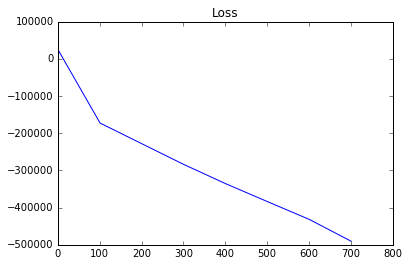

In [23]:
log = model.log
log = np.array(log).T
plt.plot(log[0,], log[1,])
plt.title('Loss')
plt.show()

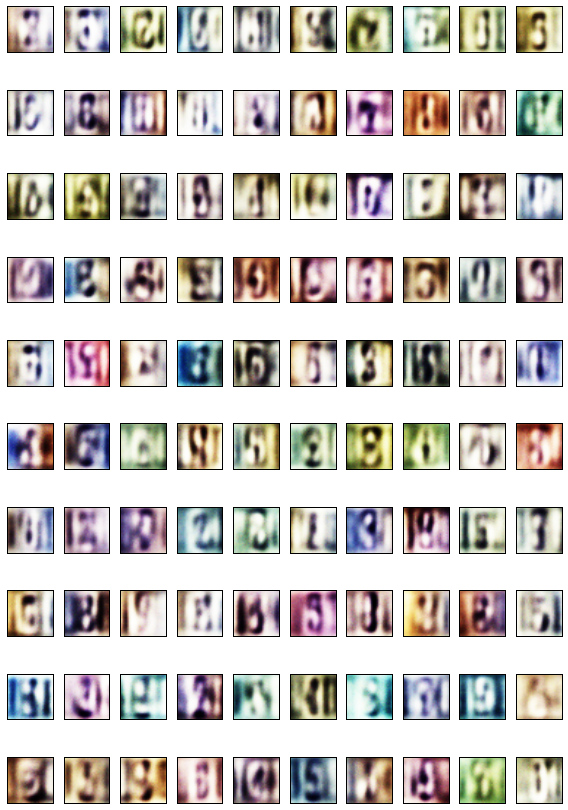

In [28]:
#images, info = mnist.test.next_batch(100)
num_examples = 10
batch_size = 1000

labels = np.repeat(np.identity(10), 100, axis=0)
generated_images = model.generate(num=batch_size, labels=labels)


plt.figure(figsize=(8,12))
for i in xrange(10):
    for j in xrange(num_examples):
        plt.subplot(10, num_examples, 10*i+j+1)
        plt.imshow(generated_images[100*i+j,].reshape(32,32,3))
        plt.xticks([])
        plt.yticks([])
plt.tight_layout()
plt.savefig('images/SVHN_generate')
plt.show()